# Dataset evaluation based on Fréchet inception distance-based score

This script uses extracted image features to calculate a dataset based score of dataset classification difficulty using a Fréchet inception distance (FID)-based score. This script was used for dataset difficulty estimation of the conference paper by Thornblad et al. [1]. 

This metric is commonly used to analyze synthetic images created using generative adversarial networks. In this work, this metric is used to compute a dataset difficulty score, based on the implementation of Scheidegger et al. [2]. This score is determined by calculating the within-class FID score ($FID_{ii}$) and the between-class FID score ($FID_{ij}$) based on the image features. The $FID_{ij}$ score is determined using equation below between the two class subsets, whereas the $FID_{ii}$ score is determined within a class by dividing the class subset into two subsets, of equal size, and calculating the FID~score using these two datasets. This score is calculated using

\begin{equation} 
    FID = ||\mu_A - \mu_B || + Tr (\Sigma_A + \Sigma_B -2 (\Sigma_A \Sigma_B)^{1/2}),
\end{equation}

where $\mu_A$ and $\mu_B$ are the mean vectors and $\Sigma_A$ and $\Sigma_B$ are the covariance matrices of two datasets, $A$ and $B$. 

Since there will be one $FID_{ii}$ score determined for each class, the lowest of the two scores is used for further calculations, in alignment with the method proposed by Scheidegger et al. [1]. This $FID_{ii}$ score is used as a normalization coefficient in the formula given in the equation below to compute the dataset level FID~score:

\begin{equation}
    f = 
    \begin{cases}
      1 - FID_{ii} /FID_{ij} & \text{if } FID_{ii} < FID_{ij}  \\
      0 & \text{if } FID_{ii} = FID_{ij} \\
      FID_{ij} /FID_{ii} - 1  & \text{if } FID_{ii} > FID_{ij}.
    \end{cases} 
\end{equation}


[1] Estimating the difficulty of medical classification tasks using 3D image datasets, Thornblad et al., 2025


[2] Efficient image dataset classification difficulty estimation for predicting deep-learning accuracy, Florian Scheidegger et al., 2020
https://link.springer.com/article/10.1007/s00371-020-01922-5

In [ ]:
import numpy as np
import os
from scipy.stats import linregress
import csv
import matplotlib.pyplot as plt
import scipy.stats as stats
import statistics
import time
import utils

In [ ]:
# Paths for project

# Ovarian paths
data_p = './Dataset_ovarian'
preprocessed_p = './Dataset_ovarian/Preprocessed_data_RADIOMICS'

# Pancreas paths
data_p = './Pancreas_cropped'
preprocessed_p = './Pancreas_cropped/Preprocessed_data_RADIOMICS'


# LIDC paths 
data_p = './NIFTI-LIDC'
preprocessed_p = './NIFTI-LIDC/Preprocessed_data_RADIOMICS'

# Liver dataset paths
data_p = './Liver_LITS17'
preprocessed_p = './Liver_LITS17/Preprocessed_data_RADIOMICS'

# FractureMNIST3D
data_p = './MedMNIST/FractureMNIST3D'
preprocessed_p = './MedMNIST/FractureMNIST3D/Preprocessed_data_RADIOMICS'

## Fréchet inception distance (FID) score calculation


In [ ]:
# Calculate FID score for one dataset

feature_json_path = preprocessed_p  + '_FAST'
full_dataset_features, class_1_features, class_0_features = utils.load_features_full_dataset(feature_json_path)

f = utils.FID_metric_calc(class_0_features, class_1_features)
print('f', f)

In [ ]:
## Estimate inference time of FID score calc
feature_json_path = preprocessed_p  + '_FAST'
full_dataset_features, class_1_features, class_0_features = utils.load_features_full_dataset(feature_json_path)


num_runs = 5

all_times = []
scores_list = []

for run in range(num_runs):
    start_time = time.time()
    # Process each image in the dataset
    f = utils.FID_metric_calc(class_0_features, class_1_features)
    end_time = time.time()

    elapsed_time = end_time - start_time
    all_times.append(elapsed_time)
    scores_list.append(f)
    print(f"Run {run+1}/{num_runs}: {elapsed_time:.4f} seconds")

avg_time = statistics.mean(all_times)
print(f"\nAverage Inference Time over {num_runs} runs: {avg_time:.4f} seconds")



### FID score calculation with bootstrapping

In [ ]:
# Calculate FID score for a bootstrapped dataset (block bootstrapping) using radiomic features


feature_json_path = preprocessed_p  + '_FAST'
full_dataset_features, patient_IDs_0, patient_IDs_1, class_1_features, IDs_1, class_0_features, IDs_0 = utils.load_features_full_dataset_patient_wise(feature_json_path)

val_array = utils.bootstrap_with_blocks_patient_wise(class_0_features, class_1_features, patient_IDs_0, patient_IDs_1, IDs_0, IDs_1, utils.FID_metric_calc, n_sessions=1000, b_0=0.6, b_1=0.6)


In [ ]:
# Calculate FID score for a bootstrapped dataset (block bootstrapping) using deep learning encoded features

base_p = './Fréchet_inception_distance/image_features_MedicalNet'
class_0_name = 'liver_image_features_0.csv'
class_1_name = 'liver_image_features_1.csv'
csv_path_0 = os.path.join(base_p, class_0_name)
csv_path_1 = os.path.join(base_p, class_1_name)
class_0_features, class_1_features = utils.read_MedicalNet_features_FID(csv_path_0, csv_path_1)
val_array = utils.bootstrap_with_blocks(class_0_features, class_1_features, utils.FID_metric_calc, n_sessions=10, b_0=0.6, b_1=0.6)

### Multi dataset bootstrapping FID calculation scripts

In [ ]:
### Script for Radiomic encoded features
# Paths for project
# Ovarian paths
ovarian_preprocessed_p = './Dataset_ovarian/Preprocessed_data_RADIOMICS'

# Pancreas paths
pancreas_preprocessed_p = './Pancreas_cropped/Preprocessed_data_RADIOMICS'


# LIDC paths Eloy processed
LIDC_preprocessed_p = './NIFTI-LIDC/Preprocessed_data_RADIOMICS'

# FractionMNIST paths
MNIST_preprocessed_p = './MedMNIST/FractureMNIST3D/Preprocessed_data_RADIOMICS'

Liver_preprocessed_p = './Liver_LITS17/Preprocessed_data_RADIOMICS'



preprocessing_paths = [ovarian_preprocessed_p, pancreas_preprocessed_p, MNIST_preprocessed_p, LIDC_preprocessed_p, Liver_preprocessed_p]
dataset_names = ['Ovarian', 'Pancreas', 'MNIST', 'LIDC', 'Liver']

# preprocessing_paths = [ovarian_preprocessed_p, pancreas_preprocessed_p, MNIST_preprocessed_p, LIDC_preprocessed_p]
# dataset_names = ['Ovarian', 'Pancreas', 'MNIST', 'LIDC']
val_lists = []
for dataset_i in range(4, len(preprocessing_paths)):
    print(f'Now processing dataset {dataset_i} ({dataset_names[dataset_i]})...')
    preprocessed_path_i = preprocessing_paths[dataset_i]
    feature_json_path = preprocessed_path_i  + '_FAST'

    full_dataset_features, class_1_features, class_0_features = utils.load_features_full_dataset(feature_json_path)

    val_array = utils.bootstrap_with_blocks(class_0_features, class_1_features, utils.FID_metric_calc, n_sessions=1000, b_0=0.6, b_1=0.6)
    val_lists.append(np.array(val_array))

    path = './Fréchet_inception_distance/Bootstrapping_scores'
    file_name = f'FID_scores_{dataset_names[dataset_i]}.csv'
    csv_save_path = os.path.join(path, file_name)
    with open(csv_save_path, 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(val_array)

In [ ]:
### Script for MedicalNet encoded features
# Paths for project

base_p = './Fréchet_inception_distance/image_features_MedicalNet'


dataset_names = ['Ovarian', 'pancreas', 'lung', 'MNIST', 'liver']

# preprocessing_paths = [ovarian_preprocessed_p, pancreas_preprocessed_p, MNIST_preprocessed_p, LIDC_preprocessed_p]
# dataset_names = ['Ovarian', 'Pancreas', 'MNIST', 'LIDC']
val_lists = []
for dataset_i in range(len(dataset_names)):
    data_name = dataset_names[dataset_i]
    print(f'Now processing dataset {dataset_i} ({data_name})...')

    class_0_name = f'{data_name}_image_features_0.csv'
    class_1_name = f'{data_name}_image_features_1.csv'

    csv_path_0 = os.path.join(base_p, class_0_name)
    csv_path_1 = os.path.join(base_p, class_1_name)
    class_0_features, class_1_features = utils.read_MedicalNet_features(csv_path_0, csv_path_1)

    val_array = utils.bootstrap_with_blocks(class_0_features, class_1_features, utils.FID_metric_calc, n_sessions=1000, b_0=0.6, b_1=0.6)
    val_lists.append(np.array(val_array))

    path = './Fréchet_inception_distance/Bootstrapping_scores/Medical_Net_bootstrap_scores'
    file_name = f'FID_scores_{data_name}.csv'
    csv_save_path = os.path.join(path, file_name)
    with open(csv_save_path, 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(val_array)

### Plot FID scores


Now processing dataset 0 (Ovarian)...
data and AUC shape: (1000,) 1000
Now processing dataset 1 (Pancreas)...
data and AUC shape: (1000,) 1000
Now processing dataset 2 (LIDC)...
data and AUC shape: (1000,) 1000
Now processing dataset 3 (MNIST)...
data and AUC shape: (1000,) 1000
Now processing dataset 4 (Liver)...
data and AUC shape: (1000,) 1000
Pearson Correlation Coefficient: 0.2634
P-value: 0.0000
Significant correlation found!


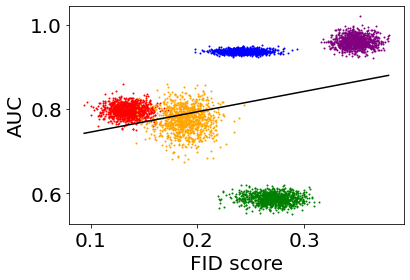

In [ ]:
## Script for plotting all values as dots (all same AUC per dataset)

# Path to csv files of bootstrapped vals
path = './Fréchet_inception_distance/Bootstrapping_scores'

plt.rcParams.update({'font.size': 20})

# # AUC scores per fold for 3DCNN model
# AUCs_ovarian = [0.6539408866995073, 0.5829228243021346, 0.6120689655172414, 0.6288998357963875, 0.35714285714285715]
# AUCs_pancreas = [0.4772727272727273, 0.5568181818181819, 0.6003787878787878, 0.6439393939393939, 0.5776515151515151]
# AUCs_MNIST = [0.6212086917157085, 0.6123811679492983, 0.5768447261204165, 0.5511543684925305, 0.6140787686736079]
# AUCs_LIDC = [0.8717008797653959, 0.8340664711632453, 0.852394916911046, 0.8318670576735092, 0.8658357771260997]
# AUCs_Liver = [0.900462962962963, 0.8472222222222222, 0.8796296296296297, 0.8472222222222223, 0.9259259259259258]

# AUC scores per fold for MILCNN model
AUCs_ovarian = [0.8123973727422004, 0.7881773399014779, 0.784072249589491, 0.7836617405582923, 0.8160919540229885]
AUCs_pancreas = [0.8181818181818182, 0.7310606060606062, 0.7632575757575757, 0.7954545454545454, 0.7594696969696969]
AUCs_MNIST = [0.5680172023540063, 0.5866908103214123, 0.6025350837483024, 0.5875961973743775, 0.5930285196921684]
AUCs_LIDC = [0.936217008797654, 0.9401270772238515, 0.9420821114369502, 0.9349951124144673, 0.9301075268817204]
AUCs_Liver = [0.9722222222222223, 0.9768518518518519, 0.9606481481481481, 0.9560185185185186, 0.9374999999999999]


AUCs_list = [AUCs_ovarian, AUCs_pancreas, AUCs_LIDC, AUCs_MNIST, AUCs_Liver]
dataset_names = ['Ovarian', 'Pancreas', 'LIDC', 'MNIST', 'Liver']
# dataset_names = ['Ovarian', 'pancreas', 'lung', 'MNIST', 'liver']
colors = ['red', 'orange', 'blue', 'green', 'purple']

# fig, ax = plt.subplots()

X_val_list = np.array([])
y_val_list = np.array([])
for dataset_i in range(len(dataset_names)):
    data_name = dataset_names[dataset_i]
    print(f'Now processing dataset {dataset_i} ({data_name})...')

    file_name = f'FID_scores_{data_name}.csv'
    csv_save_path = os.path.join(path, file_name)
    with open(csv_save_path, newline='') as f:
        reader = csv.reader(f)
        data = np.array(list(reader)[0]).astype(float)
        # print(data)
        # print(data.shape)
    X_val_list = np.append(X_val_list, data)
    AUC_dataset_i = AUCs_list[dataset_i]
    # Use average AUC for all points
    # AUC_average = np.average(np.array(AUC_dataset_i))
    # y_list = np.array([AUC_average]*len(data))

    # Sample AUC based on mean and std
    AUC_average = np.average(np.array(AUC_dataset_i))
    AUC_std = np.std(np.array(AUC_dataset_i))
    AUC_random_values = np.random.normal(loc=AUC_average,scale=AUC_std, size=len(data))
    y_list = AUC_random_values
    y_val_list = np.append(y_val_list, y_list)
    print('data and AUC shape:', data.shape, len(y_list))
    dataset_plot_names = ['OVARY', 'PANCREAS', 'LIDC', 'FractureMNIST', 'LIVER']
    plt.scatter(data, y_list, c=[colors[dataset_i]], label=dataset_plot_names[dataset_i], s=1.0)
    # plt.plot(data, y_list, color=colors[dataset_i], marker='.', label=data_name)
    

res_lin = linregress(X_val_list,y_val_list)
# print('std err', std_err)
x_line_plot = np.array([np.min(X_val_list), np.max(X_val_list)])
y_list_plot = res_lin.slope * x_line_plot + res_lin.intercept



pearson_corr, p_value = stats.pearsonr(X_val_list, y_val_list)

print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation:
if p_value < 0.05:
    print("Significant correlation found!")
else:
    print("No statistically significant correlation.")



plt.plot(x_line_plot, y_list_plot, color = 'black')
# plt.fill_between(x_line_plot, y_list_plot-std_err, y_list_plot+std_err, color='gray', alpha=0.3)
# x_regplot = np.round(X_val_list, 2)
# print(x_regplot)
# ax = sns.regplot(x=x_regplot, y=y_val_list, scatter=False, robust=True, line_kws=dict(color="gray"), ci=95)

plt.xlabel('FID score')
plt.ylabel('AUC')
# lgnd = plt.legend(loc='lower right', prop={'size': 15})
# lgnd.legendHandles[0]._sizes = [40]
# lgnd.legendHandles[1]._sizes = [40]
# lgnd.legendHandles[2]._sizes = [40]
# lgnd.legendHandles[3]._sizes = [40]
# lgnd.legendHandles[4]._sizes = [40]
plt.show()